## Import Libaries

In [37]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## LOAD DATA

In [38]:
data = pd.read_csv('databricks-cluster-data\databricks-cluster-data.csv')

In [39]:
data.shape

(307342, 8)

In [40]:
data.columns

Index(['Date', 'ClusterID', 'ClusterIP', 'ClusterName', 'Environment',
       'DateTime', 'TableName', 'TableRecordCount'],
      dtype='object')

In [41]:
df = data[['DateTime','TableName','TableRecordCount']]

In [42]:
df['DateTime'] = pd.to_datetime(df['DateTime'],utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307342 entries, 0 to 307341
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   DateTime          307342 non-null  datetime64[ns, UTC]
 1   TableName         307342 non-null  object             
 2   TableRecordCount  307342 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 7.0+ MB


<ipython-input-42-95dcb8f4e8d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'],utc=True)


In [43]:
df = df.set_index('DateTime')
df = df.sort_index()

In [44]:
df.shape

(307342, 2)

## Group data by 15 mins

In [45]:
df_all = df.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum)

In [46]:
df_all

TableRecordCount
DateTime                                   
2021-11-01 00:00:00+00:00             56929
2021-11-01 00:15:00+00:00             85724
2021-11-01 00:30:00+00:00             68082
2021-11-01 00:45:00+00:00             45065
2021-11-01 01:00:00+00:00            115849
...                                     ...
2021-11-07 22:45:00+00:00            112995
2021-11-07 23:00:00+00:00            144090
2021-11-07 23:15:00+00:00            124498
2021-11-07 23:30:00+00:00            342549
2021-11-07 23:45:00+00:00             83540

[672 rows x 1 columns]

In [47]:
df_all.describe()

TableRecordCount
count      6.720000e+02
mean       2.792239e+06
std        6.593073e+06
min        4.470000e+03
25%        3.062878e+05
50%        6.529565e+05
75%        2.137699e+06
max        7.911204e+07

<AxesSubplot:xlabel='DateTime'>

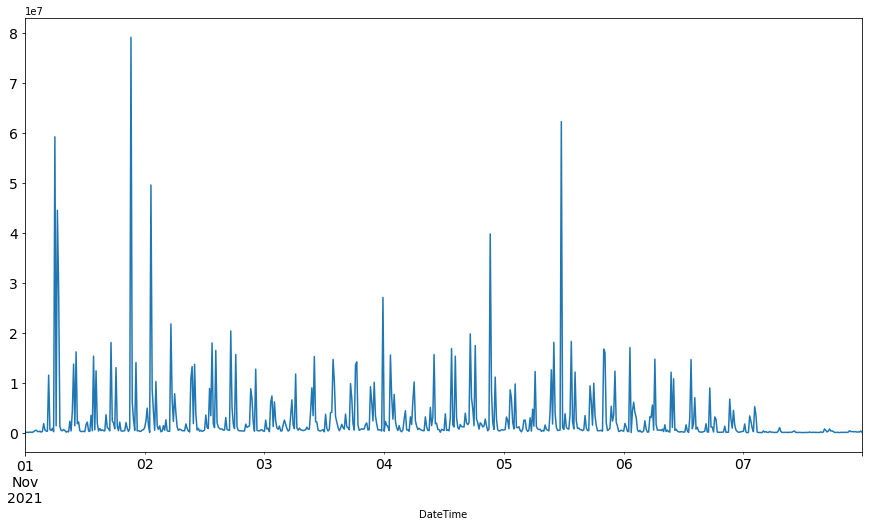

In [48]:
df_all.TableRecordCount.plot(figsize=(15,8), fontsize=14)

## Remove and smooth outliers by rolling window

In [49]:
# smooth out anomalies
def smooth_data(full_data,plot=True,verbose=True):
    for i in full_data.columns:
        full_data[i] = outlier_smoothing(full_data[i].dropna(), plot=plot,verbose = verbose)
    return full_data


def outlier_smoothing(X, contamination=0.15, smoothing_window=4, plot=True, random_state=22, verbose=True):
    """
    Outlier identification by IForest and 
    smoothing by rolling window median value
    """
    X_rolling_median = X.rolling(smoothing_window).median()
    X_rolling_mean = X.rolling(smoothing_window).mean()
    X_smoothing_ratio = X / X_rolling_median

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_rolling_median, label='rolling median')
        plt.title("Original vs. Rolling Median")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,10))
        plt.plot(X.index, X_smoothing_ratio, label="original:smoothing ratio")
        plt.title("Smoothing Ratio")
        plt.legend()
        plt.show()
    
    ## Find the outliers
    iso_forest = IsolationForest(contamination=contamination,\
        random_state=random_state)
    
    peaks = np.where(iso_forest.fit_predict(X_smoothing_ratio[smoothing_window-1:].\
        values.reshape(-1,1))<1)
    
    if verbose:
        print("Outliers found at ", X.index[peaks[0]+smoothing_window-1])
    
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index.values[peaks[0]+smoothing_window-1],\
            X.values[peaks[0]+smoothing_window-1], 'x'
            )
        plt.title("Outlier Finders")
        plt.legend()
        plt.show()
    
    ## Change the outliers with corresponding smoothed values    
    X_smoothed = X.copy()

    for i in range(len(X)):
        if np.any(peaks[0]+smoothing_window-1==i):
            X_smoothed[i] = X_rolling_mean[i]

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_smoothed, label='smoothed')
        plt.title("Original vs. smoothed")
        plt.legend()
        plt.show()
    
    return X_smoothed

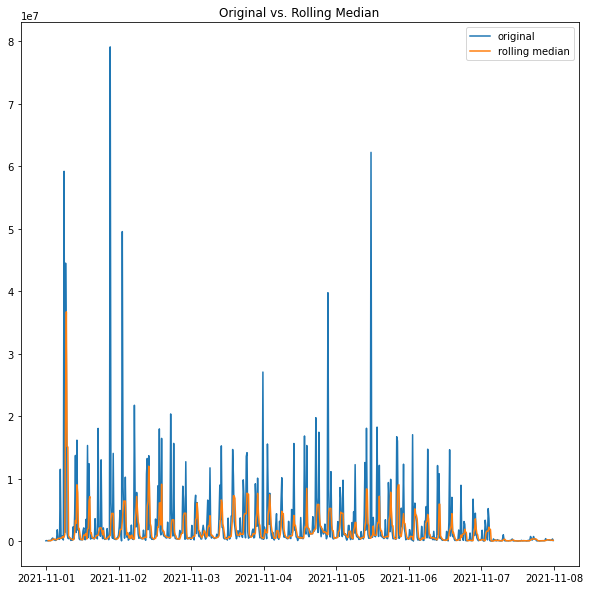

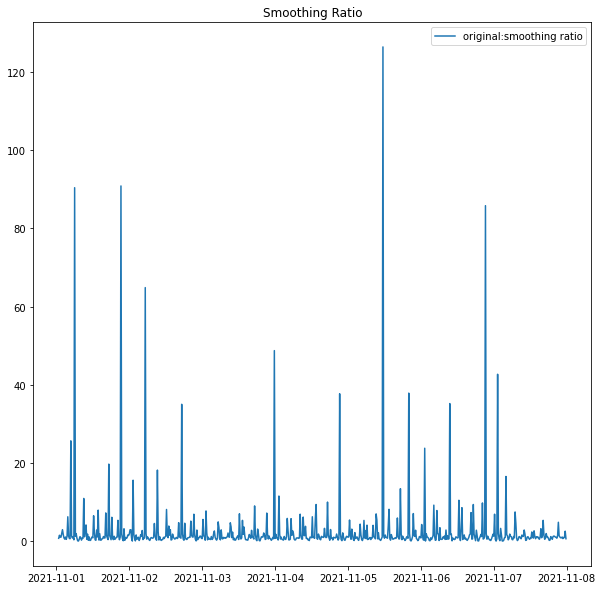

Outliers found at  DatetimeIndex(['2021-11-01 03:45:00+00:00', '2021-11-01 04:45:00+00:00',
               '2021-11-01 06:00:00+00:00', '2021-11-01 07:15:00+00:00',
               '2021-11-01 09:00:00+00:00', '2021-11-01 09:30:00+00:00',
               '2021-11-01 09:45:00+00:00', '2021-11-01 12:15:00+00:00',
               '2021-11-01 13:45:00+00:00', '2021-11-01 16:15:00+00:00',
               ...
               '2021-11-07 03:00:00+00:00', '2021-11-07 04:00:00+00:00',
               '2021-11-07 07:00:00+00:00', '2021-11-07 07:15:00+00:00',
               '2021-11-07 12:30:00+00:00', '2021-11-07 13:15:00+00:00',
               '2021-11-07 15:30:00+00:00', '2021-11-07 16:15:00+00:00',
               '2021-11-07 21:15:00+00:00', '2021-11-07 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='DateTime', length=101, freq=None)


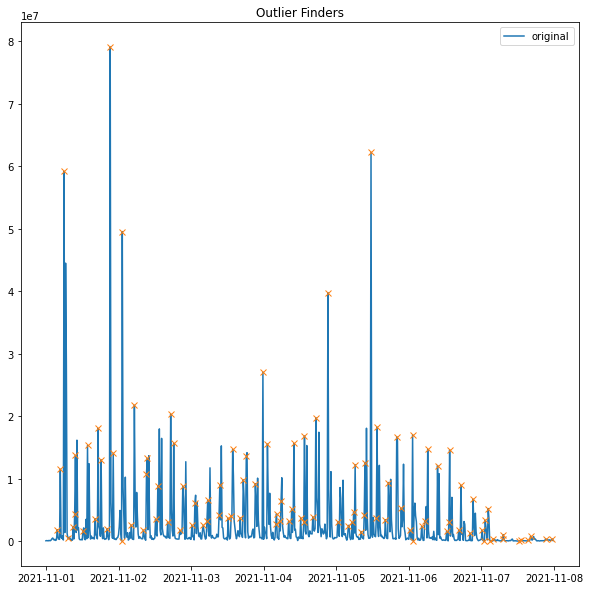

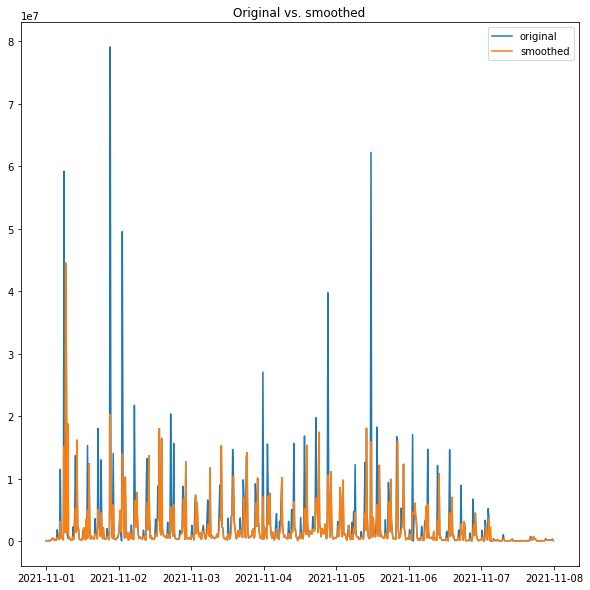

In [50]:
df_all = smooth_data(df_all)

## NORMALIZATION & STANDARDIZATION

In [51]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_all)
normalized = scaler.transform(df_all)

scaler = StandardScaler()
scaler = scaler.fit(normalized)
normalized = scaler.transform(normalized)

In [53]:
new_df = pd.DataFrame(normalized)
new_df.index = df_all.index
new_df

0
DateTime                           
2021-11-01 00:00:00+00:00 -0.505240
2021-11-01 00:15:00+00:00 -0.497293
2021-11-01 00:30:00+00:00 -0.502161
2021-11-01 00:45:00+00:00 -0.508514
2021-11-01 01:00:00+00:00 -0.488979
...                             ...
2021-11-07 22:45:00+00:00 -0.489766
2021-11-07 23:00:00+00:00 -0.481185
2021-11-07 23:15:00+00:00 -0.486592
2021-11-07 23:30:00+00:00 -0.470989
2021-11-07 23:45:00+00:00 -0.497895

[672 rows x 1 columns]

## SPLIT DATA

In [54]:
train_df = new_df[:604]
test_df = new_df[604:]
train_df.shape,test_df.shape

((604, 1), (68, 1))

## TRAINING

In [55]:
def sarima_grid_search(y):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    return param_mini, param_seasonal_mini

In [56]:
param_mini, param_seasonal_mini = sarima_grid_search(new_df)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1724.308188591951


In [57]:
mod = sm.tsa.statespace.SARIMAX(train_df,
                                order=param_mini,
                                seasonal_order=param_seasonal_mini,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

## PREDICTION AND EVALUATION

In [58]:
pred = results.get_prediction(start=pd.to_datetime(test_df.index[0]),end = pd.to_datetime(test_df.index[-1]),dynamic=True)
pred_ci = pred.conf_int()
mse = mean_squared_error(test_df.values, pred.predicted_mean)
np.sqrt(mse)

0.3316149689811032

## FORECASTING

In [73]:
mod = sm.tsa.statespace.SARIMAX(df_all,
                                order=param_mini,
                                seasonal_order=param_seasonal_mini,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
forecast = results.get_forecast(steps=20) # change here for more results
forecast.predicted_mean = abs(forecast.predicted_mean)

<Figure size 1296x576 with 0 Axes>

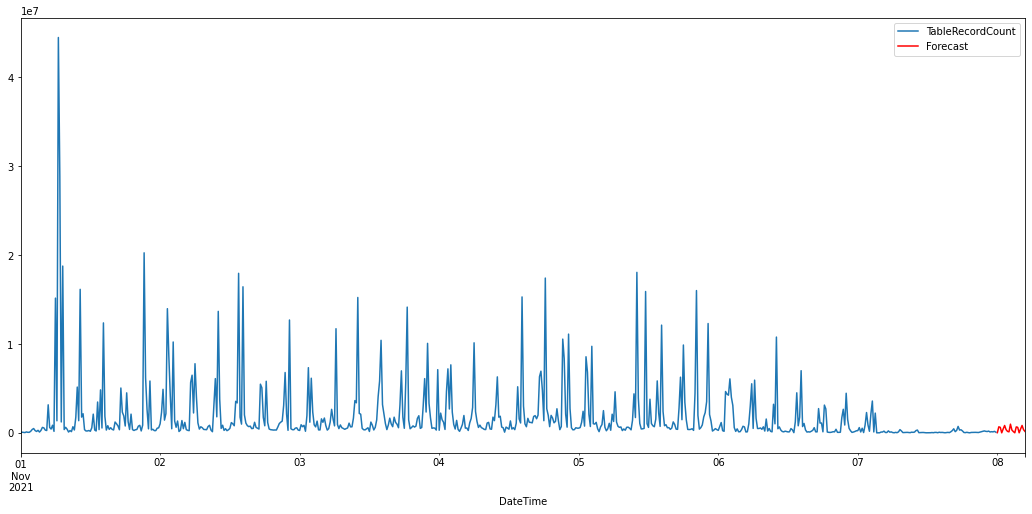

In [74]:
pd.plotting.register_matplotlib_converters()
matplotlib.rcParams['figure.figsize'] = 18, 8                                                     
plt.figure()
ax = df_all[:].plot()
forecast.predicted_mean.plot(ax = ax ,color='red',label='Forecast')
plt.legend()
plt.show()

## Save Output

In [72]:
pd.DataFrame(forecast.predicted_mean).to_csv('forecasts.csv')

## Predicting distribution for all tables count

In [75]:
tables = pd.DataFrame(df['TableName'].value_counts())
tables = tables.reset_index()
tables.columns =['Name', 'count']
tables = tables.loc[tables ['count']>= 50 ,'Name'].to_list() # taking only tables which are having more than 50 rows

In [76]:
# predicting for steps
# 1 hr = 4 -> 15 min intervals
# 24 hr = 4*24 = 96-> 15 min intervals
# 1 week = 24*7*96 = 672 -> 15 min intervals

In [77]:
%%time 
# takes around - 5-10 mins
results = pd.DataFrame()
for table in tables[:]:
    df_table = df[df['TableName'] == table]
    df_table = df_table.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum)
    df_table = df_table.fillna(0)
    mod = sm.tsa.statespace.SARIMAX(df_table,
                            order=param_mini,
                            seasonal_order=param_seasonal_mini,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    preds = mod.fit()
    forecast = preds.get_forecast(steps=672)        
    results[table]= abs(forecast.predicted_mean)

C:\Users\SO20057657\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\SO20057657\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\SO20057657\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wall time: 12min 2s


In [78]:
results = results.fillna(0)
results

mrc_vttk    eu2_mchb    mrc_lqua    mrc_mard  \
2021-11-08 00:00:00+00:00   110.707709   36.440214   17.067349  181.743930   
2021-11-08 00:15:00+00:00   243.244622   49.774507   25.317710  108.200307   
2021-11-08 00:30:00+00:00    30.594065   63.398391   13.913833  162.361485   
2021-11-08 00:45:00+00:00   113.863080    8.965382   55.244519   48.606969   
2021-11-08 01:00:00+00:00   552.017427   98.342044  505.569039  574.938673   
...                                ...         ...         ...         ...   
2021-11-14 22:45:00+00:00   230.623827   55.244179  432.271785  145.705745   
2021-11-14 23:00:00+00:00   161.771991   95.789040  448.361414  151.863251   
2021-11-14 23:15:00+00:00     9.507837   52.510090  344.479067   34.884615   
2021-11-14 23:30:00+00:00  1140.060426  364.327544  884.353901  553.049946   
2021-11-14 23:45:00+00:00   129.043478   63.722375  396.764484  100.466924   

                            mrc_qals  llv_lot_sampling_point   eu2_qals  \
2021-11-08 00:00:00+00:00   5.746485               14.218893   3.592458   
2021-11-08 00:15:00+00:00  12.351571               14.612469   4.172111   
2021-11-08 00:30:00+00:00   5.695538               10.559721   5.666933   
2021-11-08 00:45:00+00:00   4.772901               14.077865  86.074413   
2021-11-08 01:00:00+00:00  51.602929               29.610894  36.389348   
...                              ...                     ...        ...   
2021-11-14 22:45:00+00:00  19.724528                6.927024  78.024506   
2021-11-14 23:00:00+00:00  17.220400                9.373194  50.799953   
2021-11-14 23:15:00+00:00   7.698946                8.911700  42.264781   
2021-11-14 23:30:00+00:00  16.370690               48.296603  71.755632   
2021-11-14 23:45:00+00:00  95.022950                7.393629  67.527430   

                            sus_mkpf   sus_mchb  llv_c_lot_splits  ...  \
2021-11-08 00:00:00+00:00   7.909656   5.965394         17.204566  ...   
2021-11-08 00:15:00+00:00  14.098373   8.922674         18.870683  ...   
2021-11-08 00:30:00+00:00   6.906937   6.961442         13.712454  ...   
2021-11-08 00:45:00+00:00  10.462519   0.794064         17.659592  ...   
2021-11-08 01:00:00+00:00  37.879062  42.812644         38.011168  ...   
...                              ...        ...               ...  ...   
2021-11-14 22:45:00+00:00   3.430842   3.195127         11.383298  ...   
2021-11-14 23:00:00+00:00   4.002780   3.864390         13.561259  ...   
2021-11-14 23:15:00+00:00   5.207459   3.681026         12.298233  ...   
2021-11-14 23:30:00+00:00  60.967398  81.986365         57.338587  ...   
2021-11-14 23:45:00+00:00   3.332156  12.894640         12.654705  ...   

                           mrc_qmur  pda_ekes  eu2_yslsgrc   atl_vbrk  \
2021-11-08 00:00:00+00:00  0.113948  0.466247    14.265415   6.892516   
2021-11-08 00:15:00+00:00  0.002837  0.381956    11.598606  14.873977   
2021-11-08 00:30:00+00:00  0.052719  0.082196    11.868109   1.314856   
2021-11-08 00:45:00+00:00  0.076911  0.257089    13.204296   1.421276   
2021-11-08 01:00:00+00:00  0.267171  0.689339    15.710130   9.726898   
...                             ...       ...          ...        ...   
2021-11-14 22:45:00+00:00  0.000000  1.079301     0.000000   0.000000   
2021-11-14 23:00:00+00:00  0.000000  0.990015     0.000000   0.000000   
2021-11-14 23:15:00+00:00  0.000000  1.204300     0.000000   0.000000   
2021-11-14 23:30:00+00:00  0.000000  0.759984     0.000000   0.000000   
2021-11-14 23:45:00+00:00  0.000000  1.222158     0.000000   0.000000   

                           cla_ztc2c_edi_item  cla_ztc2c_edi_header  atl_qase  \
2021-11-08 00:00:00+00:00          217.729402             31.252719  0.501544   
2021-11-08 00:15:00+00:00          177.083450             15.318379  0.282574   
2021-11-08 00:30:00+00:00           58.076542              1.426521  0.055372   
2021-11-08 00:45:00+00:00          195.294937             28.175306  0.894646   
2021-11-08 01:00:00+0

In [79]:
pd.DataFrame(results).to_csv('forecasts_tables.csv')